Источник данных https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
---
Импорт библиотек

In [1]:
import math
from IPython.display import display

import matplotlib
matplotlib.rc_file_defaults()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from matplotlib import gridspec

from scipy import stats
import statsmodels.api as sm

from matplotlib.lines import Line2D
%matplotlib inline

from matplotlib import style
style.use('bmh')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.neighbors import LocalOutlierFactor

---
## 1. Разведочный анализ

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---
1.2. Выявление пропущенных значений и их обработка

---

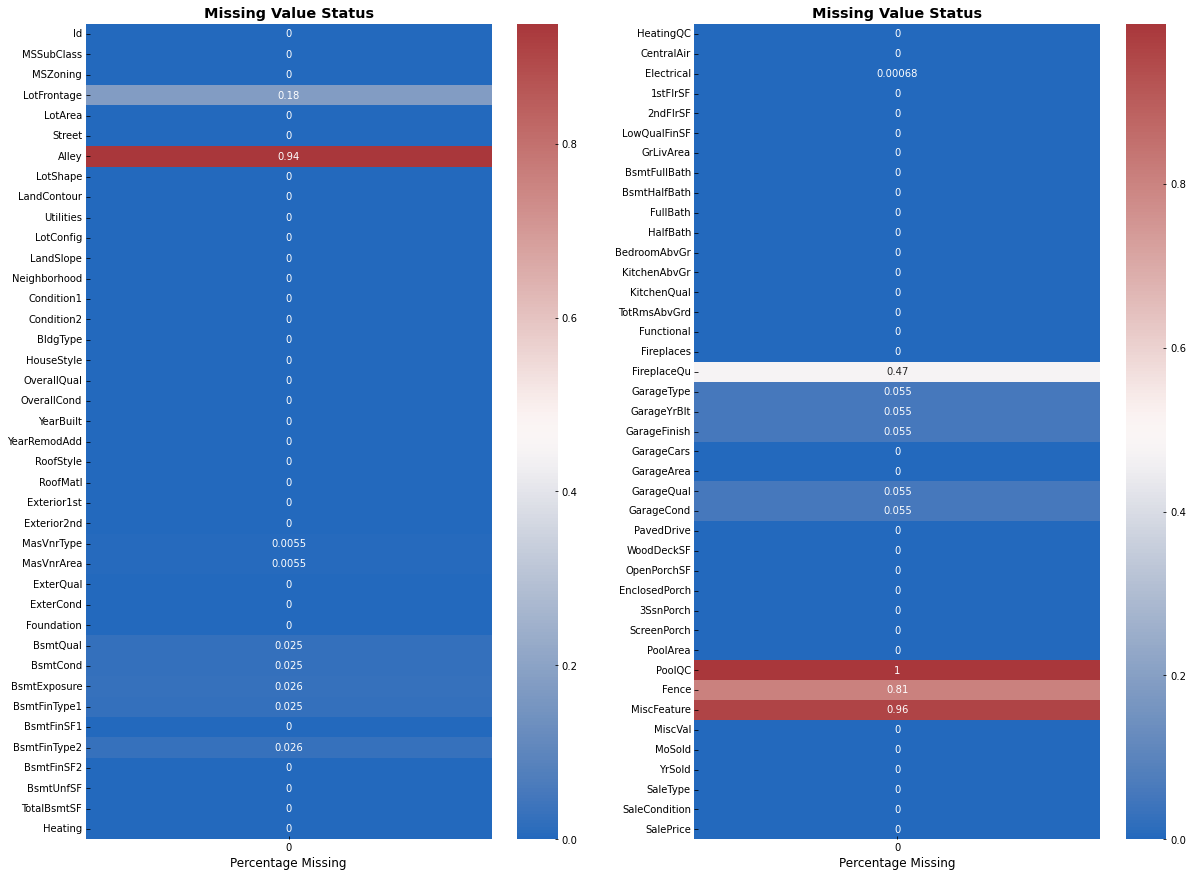

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (20, 15))
sns.heatmap(df[df.columns[:40]].isna().mean().to_frame(),annot=True,cmap='vlag', ax = axs[0]).set_title('Missing Value Status',fontweight='bold');
sns.heatmap(df[df.columns[40:]].isna().mean().to_frame(),annot=True,cmap='vlag', ax = axs[1]).set_title('Missing Value Status',fontweight='bold');
axs[0].set_xlabel('Percentage Missing');
axs[1].set_xlabel('Percentage Missing');

Очень много пропусков по признакам MiscFeature, PoolQC, Fence. Заполнять их нет смысла, лучше просто удалить. Но Fence - это качество забора. Тут скорее важно само его наличие, поэтому лучше его просто перекодировать и сделать признак бинарным (не обращать внимание на материал забора). То же самое с признаком Alley. Бассейн работает по такой же логике, но домов с бассейном меньше процента, поэтому его просто удалим.

In [4]:
df.drop(columns = ['MiscFeature', 'PoolQC', 'PoolArea', 'MiscVal', 'Id'], inplace=True)

Признак FireplaceQu содержит почти половину пропусков. Но если мы посмотрим в описание данных, то обнаружим, что это не пропуски, а просто отсутствие камина. Поэтому просто заменим NA на новый признак - собственно отсутствие камина.

In [5]:
df['Fence'].fillna(0, inplace = True)
df['Fence'] = df['Fence'].map(lambda x: 1 if x != 0 else x)

df['Alley'].fillna(0, inplace = True)
df['Alley'] = df['Alley'].map(lambda x: 1 if x != 0 else x)

df['FireplaceQu'].fillna('No', inplace = True)

По остальным признакам с пропусками ситуация в общем та же, NA значит отсутствие соответствующей характеристики. Заполнять модой, разумеется, смысла нет. В то же время значения достаточно малочисленные, но по смыслу следует все-таки создать для них отдельные категории

In [6]:
fill_qual_cols = ['MasVnrType', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond']
fill_num_cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', ]
[df[col].fillna('No', inplace = True) for col in fill_qual_cols];
[df[col].fillna(0, inplace = True) for col in fill_num_cols];

---
1.3. Оценка связи между признаками

---

Разделим признаки по типам.

In [7]:
data_types = df.dtypes
cat_cols = [df.columns[i] for i in range(df.shape[1]) if data_types[i] == 'O']
num_cols = [df.columns[i] for i in range(df.shape[1]) if data_types[i] != 'O']
target_col = num_cols.pop(-1)

print(f'Numeric features amount: {len(num_cols)}')
print(f'Categorical features amount: {len(cat_cols)}')

Numeric features amount: 36
Categorical features amount: 39


In [8]:
df.describe(include='number')

,MSSubClass,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,0.062329,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,0.192466,6.321918,2007.815753,180921.195890
std,42.300571,34.664304,9981.264932,0.241835,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,0.394372,2.703626,1.328095,79442.502883
min,20.000000,0.000000,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,42.000000,7553.500000,0.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,63.000000,9478.500000,0.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,0.000000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,1.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,1.000000,12.000000,2010.000000,755000.000000


Посмотрим у каких числовых признаков много различных значений, чтобы построить pairplot, иначе будет ничего не видно, потому что признаков слишком много. Отберем те признаки, у которых более 300 уникальных значений.

In [44]:
uniq = df[[*num_cols, target_col]].apply(lambda x: len(x.unique()))
uniq[uniq>=300]

LotArea        1073
MasVnrArea      327
BsmtFinSF1      637
BsmtUnfSF       780
TotalBsmtSF     721
1stFlrSF        753
2ndFlrSF        417
GrLivArea       861
GarageArea      441
SalePrice       663
dtype: int64

In [45]:
plot_cols

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
       'SalePrice'],
      dtype='object')

In [46]:
plot_cols = uniq[uniq>=300].index

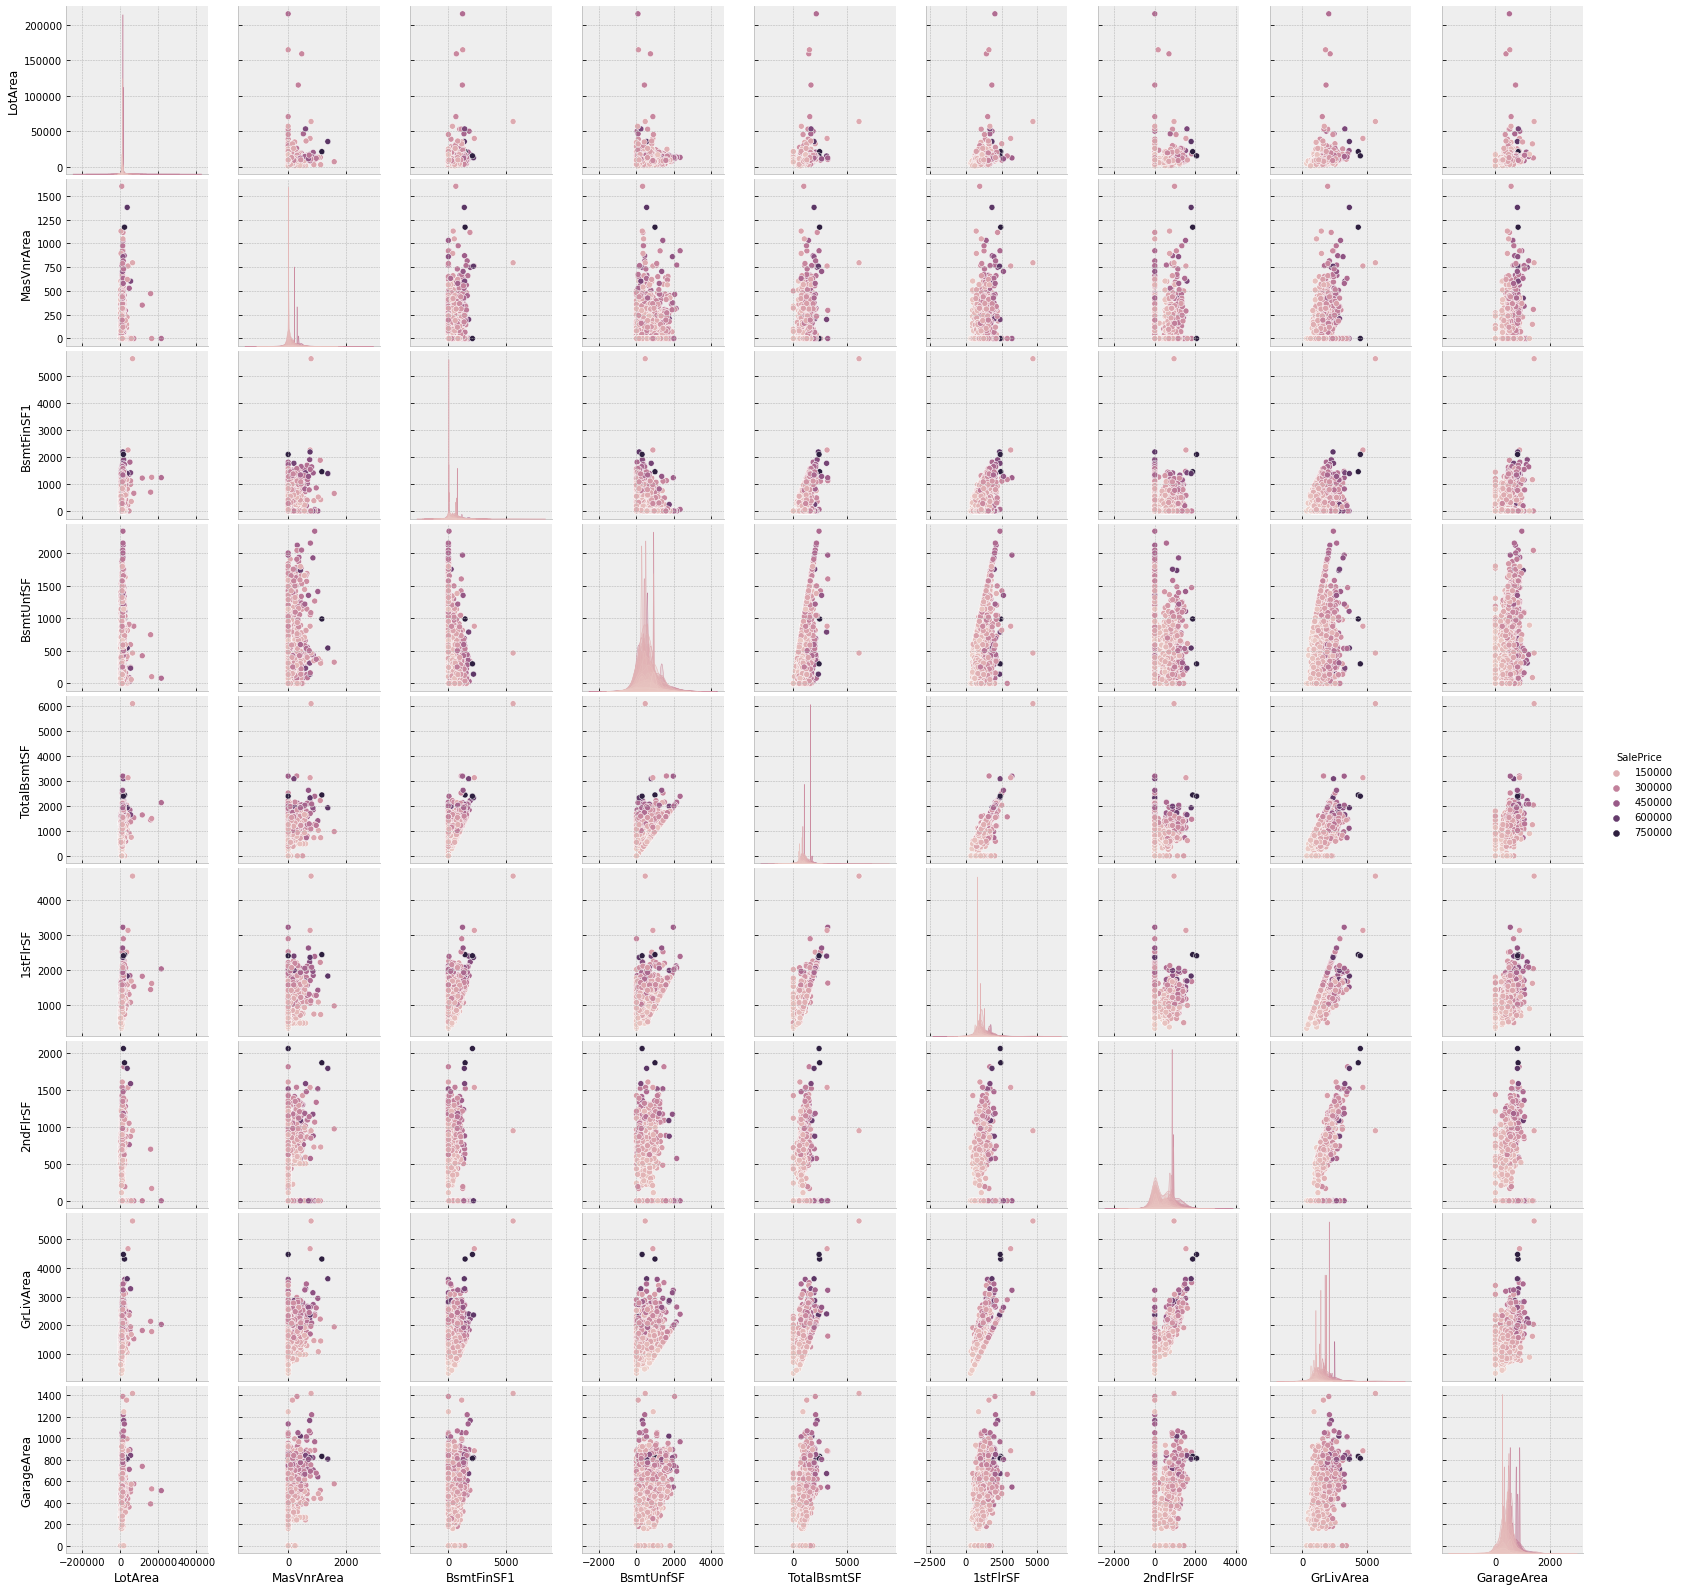

In [47]:
sns.pairplot(df[plot_cols] ,hue=target_col);

По графику видно, что некоторые признаки имеют прямую зависимость с целевым признаком. Также хорошо заметно, что есть некоторое количество выбросов, которое необходимо обработать.

Исследуем силу связи между признаками с помощью анализа корреляционной матрицы

In [12]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,MSSubClass,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SalePrice
MSSubClass,1.00,-0.22,-0.14,0.15,0.03,-0.06,0.03,0.04,0.02,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.28,0.04,-0.05,-0.08,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,-0.10,-0.01,-0.02,-0.08
LotFrontage,-0.22,1.00,0.10,-0.04,0.18,-0.05,0.04,0.08,0.11,0.08,-0.01,0.16,0.24,0.25,0.04,0.05,0.22,0.01,-0.03,0.12,-0.01,0.14,0.03,0.22,0.04,0.02,0.17,0.20,-0.02,0.07,0.03,0.02,0.02,0.01,0.02,-0.01,0.21
LotArea,-0.14,0.10,1.00,-0.08,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,-0.02,0.19,0.27,0.07,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,-0.05,0.00,-0.01,0.26
Alley,0.15,-0.04,-0.08,1.00,-0.07,0.07,-0.25,-0.03,-0.05,-0.15,-0.05,0.04,-0.13,-0.14,0.10,0.05,-0.01,-0.11,-0.03,-0.04,-0.03,0.01,0.04,-0.03,-0.12,-0.06,-0.07,-0.08,-0.11,0.06,0.18,-0.03,-0.02,0.00,-0.02,-0.02,-0.12
OverallQual,0.03,0.18,0.11,-0.07,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,-0.18,0.43,0.40,0.29,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,-0.19,0.07,-0.03,0.79
OverallCond,-0.06,-0.05,-0.01,0.07,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.09,-0.06,-0.02,-0.01,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,0.17,-0.00,0.04,-0.08
YearBuilt,0.03,0.04,0.01,-0.25,0.57,-0.38,1.00,0.59,0.31,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,-0.17,0.10,0.15,0.27,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,-0.23,0.01,-0.01,0.52
YearRemodAdd,0.04,0.08,0.01,-0.03,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,-0.15,0.19,0.11,0.15,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,-0.16,0.02,0.04,0.51
MasVnrArea,0.02,0.11,0.10,-0.05,0.41,-0.13,0.31,0.18,1.00,0.26,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.08,0.03,0.27,0.20,0.10,-0.04,0.28,0.25,0.13,0.36,0.37,0.16,0.12,-0.11,0.02,0.06,-0.10,-0.01,-0.01,0.47
BsmtFinSF1,-0.07,0.08,0.21,-0.15,0.24,-0.05,0.25,0.13,0.26,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,-0.08,0.04,0.26,0.12,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,-0.01,-0.02,0.01,0.39


Итак, достаточно сильную связь с целевой переменной (SalePrice) имеют такие признаки, как OverallQual (общая оценка состояния дома), YearBuilt (год постройки дома), YearRemodAdd (год капитального ремонта), TotalBsmtSF (общая площадь подвала), GrLivArea (жилая площадь), TotRmsAbvGrd (общее кол-во комнат выше подвала) и GarageArea (площадь гаража).
Среди факторных признаков тесная связь заметна между TotRmsAbvGrd (общее количество комнат выше подвала) и GrLivArea (жилая площадь), между BedroomAbvGr (спальни выше подвала) и TotRmsAbvGrd (общее количество комнат выше подвала).

Исследуем силу связи между результирующим признаком (SalePrice) и категориальными признаками.

In [13]:
price_cat_df = pd.concat([df[cat_cols], df.SalePrice], axis=1)

In [14]:
price_cat_df.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,No,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,250000


In [15]:
price_cat_df['SalePriceInterval'] = pd.cut(price_cat_df.SalePrice, [34899, 400000, 800000])

In [16]:
price_cat_df.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice,SalePriceInterval
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,No,Attchd,RFn,TA,TA,Y,WD,Normal,208500,"(34899, 400000]"
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Attchd,RFn,TA,TA,Y,WD,Normal,181500,"(34899, 400000]"
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,Attchd,RFn,TA,TA,Y,WD,Normal,223500,"(34899, 400000]"
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000,"(34899, 400000]"
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,TA,Attchd,RFn,TA,TA,Y,WD,Normal,250000,"(34899, 400000]"


In [17]:
df_lst = []
for i in price_cat_df.columns[:-2]:
    cont_table = pd.crosstab(price_cat_df[i], price_cat_df['SalePriceInterval'])
    df_lst.append(cont_table)

In [18]:
for df_cat in df_lst:
    display(df_cat)

SalePriceInterval,"(34899, 400000]","(400000, 800000]"
MSZoning,,
C (all),10,0
FV,65,0
RH,16,0
RL,1124,27
RM,217,1


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Street,,
Grvl,6,0
Pave,1426,28


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
LotShape,,
IR1,471,13
IR2,35,6
IR3,10,0
Reg,916,9


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
LandContour,,
Bnk,63,0
HLS,48,2
Low,36,0
Lvl,1285,26


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Utilities,,
AllPub,1431,28
NoSeWa,1,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
LotConfig,,
Corner,260,3
CulDSac,87,7
FR2,47,0
FR3,4,0
Inside,1034,18


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
LandSlope,,
Gtl,1355,27
Mod,64,1
Sev,13,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Neighborhood,,
Blmngtn,17,0
Blueste,2,0
BrDale,16,0
BrkSide,58,0
ClearCr,28,0
CollgCr,149,1
Crawfor,51,0
Edwards,100,0
Gilbert,79,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Condition1,,
Artery,47,1
Feedr,81,0
Norm,1234,26
PosA,8,0
PosN,19,0
RRAe,11,0
RRAn,25,1
RRNe,2,0
RRNn,5,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Condition2,,
Artery,2,0
Feedr,6,0
Norm,1417,28
PosA,1,0
PosN,2,0
RRAe,1,0
RRAn,1,0
RRNn,2,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BldgType,,
1Fam,1192,28
2fmCon,31,0
Duplex,52,0
Twnhs,43,0
TwnhsE,114,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
HouseStyle,,
1.5Fin,153,1
1.5Unf,14,0
1Story,716,10
2.5Fin,7,1
2.5Unf,11,0
2Story,429,16
SFoyer,37,0
SLvl,65,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
RoofStyle,,
Flat,13,0
Gable,1131,10
Gambrel,11,0
Hip,268,18
Mansard,7,0
Shed,2,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
RoofMatl,,
ClyTile,1,0
CompShg,1408,26
Membran,1,0
Metal,1,0
Roll,1,0
Tar&Grv,11,0
WdShake,5,0
WdShngl,4,2


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Exterior1st,,
AsbShng,20,0
AsphShn,1,0
BrkComm,2,0
BrkFace,49,1
CBlock,1,0
CemntBd,55,6
HdBoard,220,2
ImStucc,1,0
MetalSd,220,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Exterior2nd,,
AsbShng,20,0
AsphShn,3,0
Brk Cmn,7,0
BrkFace,24,1
CBlock,1,0
CmentBd,55,5
HdBoard,205,2
ImStucc,9,1
MetalSd,214,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
MasVnrType,,
BrkCmn,15,0
BrkFace,432,13
No,7,1
None,860,4
Stone,118,10


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
ExterQual,,
Ex,36,16
Fa,14,0
Gd,476,12
TA,906,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
ExterCond,,
Ex,3,0
Fa,28,0
Gd,144,2
Po,1,0
TA,1256,26


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Foundation,,
BrkTil,145,1
CBlock,633,1
PConc,621,26
Slab,24,0
Stone,6,0
Wood,3,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BsmtQual,,
Ex,99,22
Fa,35,0
Gd,613,5
No,37,0
TA,648,1


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BsmtCond,,
Fa,45,0
Gd,63,2
No,37,0
Po,2,0
TA,1285,26


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BsmtExposure,,
Av,215,6
Gd,121,13
Mn,112,2
No,946,7


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BsmtFinType1,,
ALQ,219,1
BLQ,148,0
GLQ,396,22
LwQ,74,0
Rec,133,0
Unf,425,5


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
BsmtFinType2,,
ALQ,18,1
BLQ,33,0
GLQ,14,0
LwQ,46,0
No,38,0
Rec,53,1
Unf,1230,26


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Heating,,
Floor,1,0
GasA,1400,28
GasW,18,0
Grav,7,0
OthW,2,0
Wall,4,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
HeatingQC,,
Ex,713,28
Fa,49,0
Gd,241,0
Po,1,0
TA,428,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
CentralAir,,
N,95,0
Y,1337,28


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Electrical,,
FuseA,94,0
FuseF,27,0
FuseP,3,0
Mix,1,0
No,1,0
SBrkr,1306,28


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
KitchenQual,,
Ex,79,21
Fa,39,0
Gd,579,7
TA,735,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
Functional,,
Maj1,14,0
Maj2,5,0
Min1,31,0
Min2,34,0
Mod,14,1
Sev,1,0
Typ,1333,27


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
FireplaceQu,,
Ex,17,7
Fa,33,0
Gd,365,15
No,690,0
Po,20,0
TA,307,6


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
GarageType,,
2Types,6,0
Attchd,852,18
Basment,19,0
BuiltIn,79,9
CarPort,9,0
Detchd,386,1
No,81,0


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
GarageFinish,,
Fin,332,20
No,81,0
RFn,415,7
Unf,604,1


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
GarageQual,,
Ex,2,1
Fa,48,0
Gd,14,0
No,81,0
Po,3,0
TA,1284,27


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
GarageCond,,
Ex,2,0
Fa,35,0
Gd,9,0
No,81,0
Po,7,0
TA,1298,28


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
PavedDrive,,
N,90,0
P,30,0
Y,1312,28


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
SaleType,,
COD,43,0
CWD,4,0
Con,2,0
ConLD,9,0
ConLI,4,1
ConLw,5,0
New,107,15
Oth,3,0
WD,1255,12


SalePriceInterval,"(34899, 400000]","(400000, 800000]"
SaleCondition,,
Abnorml,100,1
AdjLand,4,0
Alloca,12,0
Family,20,0
Normal,1186,12
Partial,110,15


H0: независимость наблюдаемых частот в таблице

alpha = 0.05

In [19]:
def highlight_greaterthan_1(s):
    if s.pvalue < 0.05:
        return ['background-color: forestgreen']*2 
    else:
        return ['background-color: orangered']*2

In [20]:
chi2_result = pd.DataFrame()
chi2_result['index'] = price_cat_df.columns[:-2]
chi2_result = chi2_result.set_index('index')
chi2_result.index.name = None
for df_cat in df_lst:
    result = stats.chi2_contingency(df_cat)
    chi2_result.at[df_cat.index.name, 'statistic'] = result[0]
    chi2_result.at[df_cat.index.name, 'pvalue'] = result[1]

chi2_result = round(chi2_result, 2)

chi2_result.style.apply(highlight_greaterthan_1, axis=1)

,statistic,pvalue
MSZoning,5.370000,0.250000
Street,1.320000,0.250000
LotShape,41.350000,0.000000
LandContour,3.120000,0.370000
Utilities,12.300000,0.000000
LotConfig,17.360000,0.000000
LandSlope,0.310000,0.850000
Neighborhood,206.590000,0.000000
Condition1,3.130000,0.930000
Condition2,0.300000,1.000000


Целевая переменная SalePrice с категориальными признаками, для которых в таблице значения статистики и p-value подсвечены зеленым цветом (p-value < 0.05) имеют сильную связь, т.е. гипотеза H0 о независимости наблюдаемых частот в таблице кросс-табуляции для целевой переменной и соответствующих факторных переменных отклоняется.
Для категориальных переменных, подсвеченных красным цветом, наоборот, гипотеза H0 не отклоняется, т.е. мы не можем утверждать, что такие признаки, как MSZoning (тип локации), Condition1 (расположенный рядом объект), Condition2 (еще один расположенный рядом объект), ExterCond (состояние отделки)и т.д. имеют тесную связь с SalePrice (значимо влияют на цену продажи жилья).

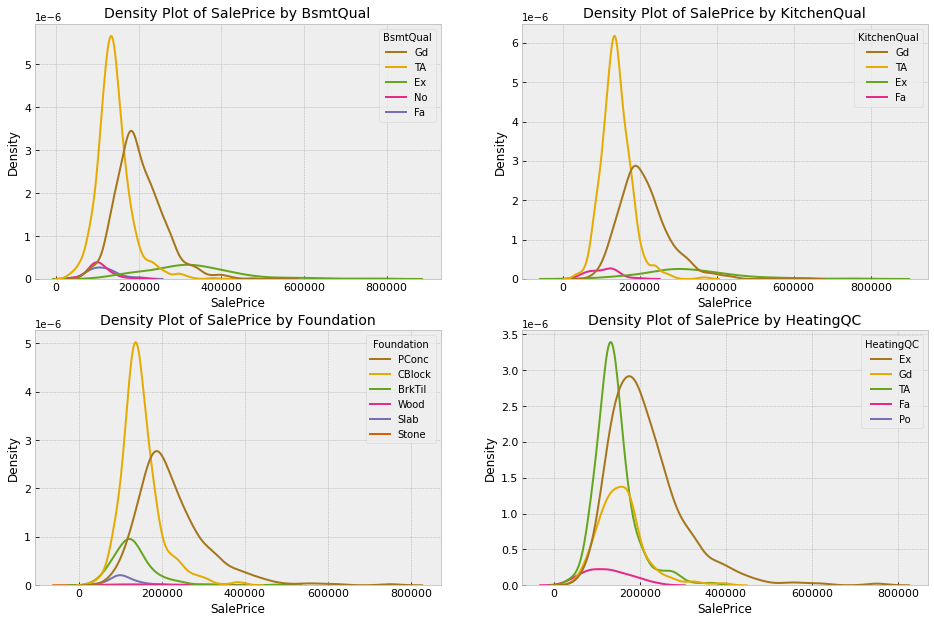

In [21]:
sns.set_palette('Dark2_r')
fig, ax = plt.subplots(2, 2, figsize=[16, 8])

ax[0,0].set_title('Density Plot of SalePrice by BsmtQual', size=14)
ax[1,0].set_title('Density Plot of SalePrice by Foundation', size=14)

ax[0,1].set_title('Density Plot of SalePrice by KitchenQual', size=14)
ax[1,1].set_title('Density Plot of SalePrice by HeatingQC', size=14)

for i, k in zip(range(2), ['BsmtQual', 'Foundation']):
    sns.kdeplot(price_cat_df['SalePrice'], hue = price_cat_df[k], ax=ax[i,0]); 
    

for i, k in zip(range(2), ['KitchenQual', 'HeatingQC']):
    sns.kdeplot(price_cat_df['SalePrice'], hue = price_cat_df[k], shade = False, ax=ax[i,1]); 

for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=11)
        
plt.subplots_adjust(top = 1.1)
    

На представленном графики изображены распределения SalePrice в зависимости от BsmtQual (качества подвала), KitchenQual (качества кухни), Foundation (типа фундамента) и HeatingQC (качества отопления). 
Видно, что отобранные категориальные признаки оказывают существенное влияние на  целевую переменную SalePrice. К примеру, по первому графику, дома с отличным качеством подвала (100+ дюймов) чаще имеют более высокую цену продажи, чем дома с типичным качеством подвала (80-89 дюймов).
По второму графику, с качеством кухни наблюдается похожая ситуация.
По третьему графику, дома, имеющие в качестве фундамента заливной бетон чаще продаются по более высокой цене, чем дома, где фундамент состоит из кирпича и плитки, древесины, шлакоблоков или камня.
По четвертому графику, с качеством отопления похожая ситуация, как и в первых двух случаях, чаще бОльшую цену продажи имеют дома с отличным качеством отопления, чем дома с плохим отоплением, что логично.

Используя Kruskal–Wallis test, проверим, равны ли медианы цен продажи жилья для групп, разделенных по значениям категориальных признаков, для которых мы получили, что они имеют значимое влияние на цену продажи жилья.

In [22]:
kruskal_result = pd.DataFrame()
kruskal_result['index'] = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'ExterQual', 'BsmtQual',
                            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual']
kruskal_result = kruskal_result.set_index('index')
kruskal_result.index.name = None

for column in kruskal_result.index[5:]:
    result = stats.kruskal(price_cat_df[price_cat_df[column] == "Ex"]['SalePrice'], price_cat_df[price_cat_df[column] == "Gd"]['SalePrice'],     
    price_cat_df[price_cat_df[column] == "TA"]['SalePrice'], price_cat_df[price_cat_df[column] == "Fa"]['SalePrice'])
    kruskal_result.at[column, 'statistic'] = result[0]
    kruskal_result.at[column, 'pvalue'] = result[1]

result1 = stats.kruskal(price_cat_df.query('RoofStyle == "Flat"')['SalePrice'], price_cat_df.query('RoofStyle == "Gable"')['SalePrice'],     
price_cat_df.query('RoofStyle == "Gambrel"')['SalePrice'], price_cat_df.query('RoofStyle == "Hip"')['SalePrice'], price_cat_df.query('RoofStyle == "Mansard"')['SalePrice'],     
price_cat_df.query('RoofStyle == "Shed"')['SalePrice'], price_cat_df.query('RoofStyle == "Mansard"')['SalePrice'])
kruskal_result.at['RoofStyle', 'statistic'] = result1[0]
kruskal_result.at['RoofStyle', 'pvalue'] = result1[1]

result2 = stats.kruskal(price_cat_df.query('RoofMatl == "CompShg"')['SalePrice'], price_cat_df.query('RoofMatl == "Tar&Grv"')['SalePrice'],     
price_cat_df.query('RoofMatl == "WdShngl"')['SalePrice'], price_cat_df.query('RoofMatl == "WdShake"')['SalePrice'], 
price_cat_df.query('RoofMatl == "Membran"')['SalePrice'], price_cat_df.query('RoofMatl == "Roll"')['SalePrice'],     
price_cat_df.query('RoofMatl == "Metal"')['SalePrice'], price_cat_df.query('RoofMatl == "ClyTile"')['SalePrice'])
kruskal_result.at['RoofMatl', 'statistic'] = result2[0]
kruskal_result.at['RoofMatl', 'pvalue'] = result2[1]

result3 = stats.kruskal(price_cat_df.query('Foundation == "PConc"')['SalePrice'], price_cat_df.query('Foundation == "CBlock"')['SalePrice'],     
price_cat_df.query('Foundation == "BrkTil"')['SalePrice'], price_cat_df.query('Foundation == "Slab"')['SalePrice'], 
price_cat_df.query('Foundation == "Stone"')['SalePrice'], price_cat_df.query('Foundation == "Wood"')['SalePrice'])    
kruskal_result.at['Foundation', 'statistic'] = result3[0]
kruskal_result.at['Foundation', 'pvalue'] = result3[1]

result4 = stats.kruskal(price_cat_df.query('Exterior1st == "VinylSd"')['SalePrice'], price_cat_df.query('Exterior1st == "HdBoard"')['SalePrice'],     
price_cat_df.query('Exterior1st == "MetalSd"')['SalePrice'], price_cat_df.query('Exterior1st == "Wd Sdng"')['SalePrice'], 
price_cat_df.query('Exterior1st == "Plywood"')['SalePrice'], price_cat_df.query('Exterior1st == "CemntBd"')['SalePrice'],     
price_cat_df.query('Exterior1st == "BrkFace"')['SalePrice'], price_cat_df.query('Exterior1st == "WdShing"')['SalePrice'],     
price_cat_df.query('Exterior1st == "Stucco"')['SalePrice'], price_cat_df.query('Exterior1st == "AsbShng"')['SalePrice'])    
kruskal_result.at['Exterior1st', 'statistic'] = result4[0]
kruskal_result.at['Exterior1st', 'pvalue'] = result4[1]

result5 = stats.kruskal(price_cat_df.query('Exterior2nd == "VinylSd"')['SalePrice'], price_cat_df.query('Exterior2nd == "MetalSd"')['SalePrice'],     
price_cat_df.query('Exterior2nd == "HdBoard"')['SalePrice'], price_cat_df.query('Exterior2nd == "Wd Sdng"')['SalePrice'], 
price_cat_df.query('Exterior2nd == "Plywood"')['SalePrice'], price_cat_df.query('Exterior2nd == "CmentBd"')['SalePrice'],     
price_cat_df.query('Exterior2nd == "Wd Shng"')['SalePrice'], price_cat_df.query('Exterior2nd == "Stucco"')['SalePrice'],
price_cat_df.query('Exterior2nd == "BrkFace"')['SalePrice'], price_cat_df.query('Exterior2nd == "AsbShng"')['SalePrice'])    
kruskal_result.at['Exterior2nd', 'statistic'] = result5[0]
kruskal_result.at['Exterior2nd', 'pvalue'] = result5[1]

kruskal_result = round(kruskal_result, 2)
kruskal_result.style.apply(highlight_greaterthan_1, axis=1)

,statistic,pvalue
RoofStyle,40.070000,0.000000
RoofMatl,18.870000,0.010000
Exterior1st,291.370000,0.000000
Exterior2nd,275.870000,0.000000
Foundation,488.720000,0.000000
ExterQual,683.440000,0.000000
BsmtQual,631.830000,0.000000
HeatingQC,354.670000,0.000000
KitchenQual,661.480000,0.000000
FireplaceQu,50.430000,0.000000


Действительно, при изменении значений данных категориальных признаков, медианные значения цены продажи значимо меняется (гипотеза H0 о том, что медианы цены продажи жилья при разных значениях категориальных признаков, представленных в таблице выше, равны, отвергается).

В качестве примера визуализируем распределение цены продажи жилья в зависимости от значений отобранных 4ех категориальных признаков (RoofStyle, KitchenQual, Foundation, BsmtQual).

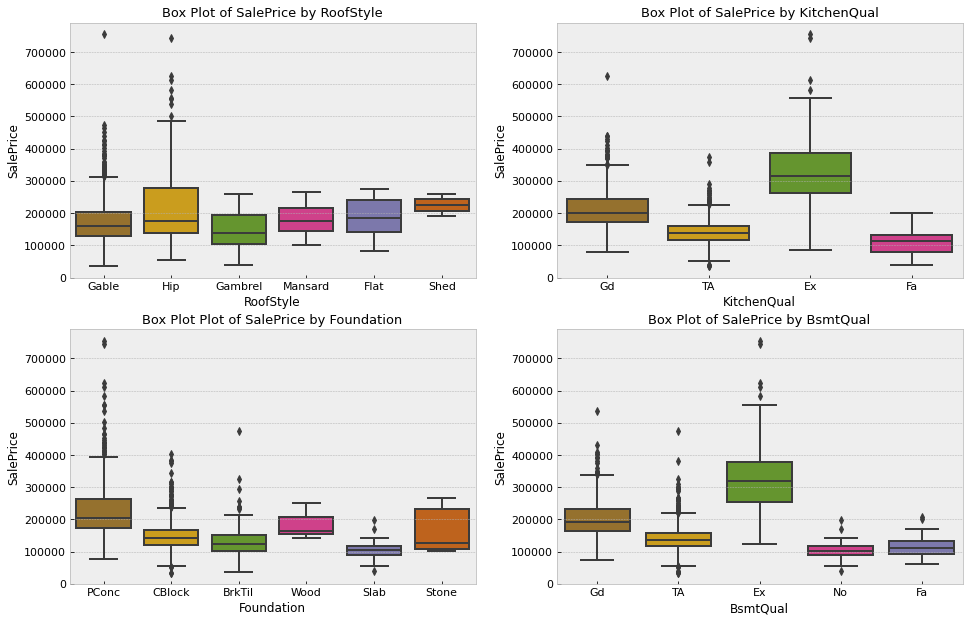

In [23]:
sns.set_palette('Dark2_r')
fig, ax = plt.subplots(2, 2, figsize=[16, 8])

ax[0,0].set_title('Box Plot of SalePrice by RoofStyle', size=13)
ax[1,0].set_title('Box Plot Plot of SalePrice by Foundation', size=13)

ax[0,1].set_title('Box Plot of SalePrice by KitchenQual', size=13)
ax[1,1].set_title('Box Plot of SalePrice by BsmtQual', size=13)

for i, k in zip(range(2), ['RoofStyle', 'Foundation']):
    sns.boxplot(x=k, y='SalePrice', data=price_cat_df, ax=ax[i, 0]);
    

for i, k in zip(range(2), ['KitchenQual', 'BsmtQual']):
    sns.boxplot(x=k, y='SalePrice', data=price_cat_df, ax=ax[i, 1]);
    
for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(top = 1.1)

По графикам box plot также заметно, что медианы цены продажи значительно изменяются при изменении значения категориального признака. Например, для признаков KitchenQual и BsmtQual, медиана цены продажи жилья с отличным состоянием кухни или с высотой подвала более 100 дюймов значительно превышает медианные значения цен для домов с более низким состоянием кухни или с меньшей высотой подвала.

---
1.4. Анализ признаков на нормальность распределения

---

Проведем анализ распределения числовых признаков 'SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea' и 'GarageArea'.

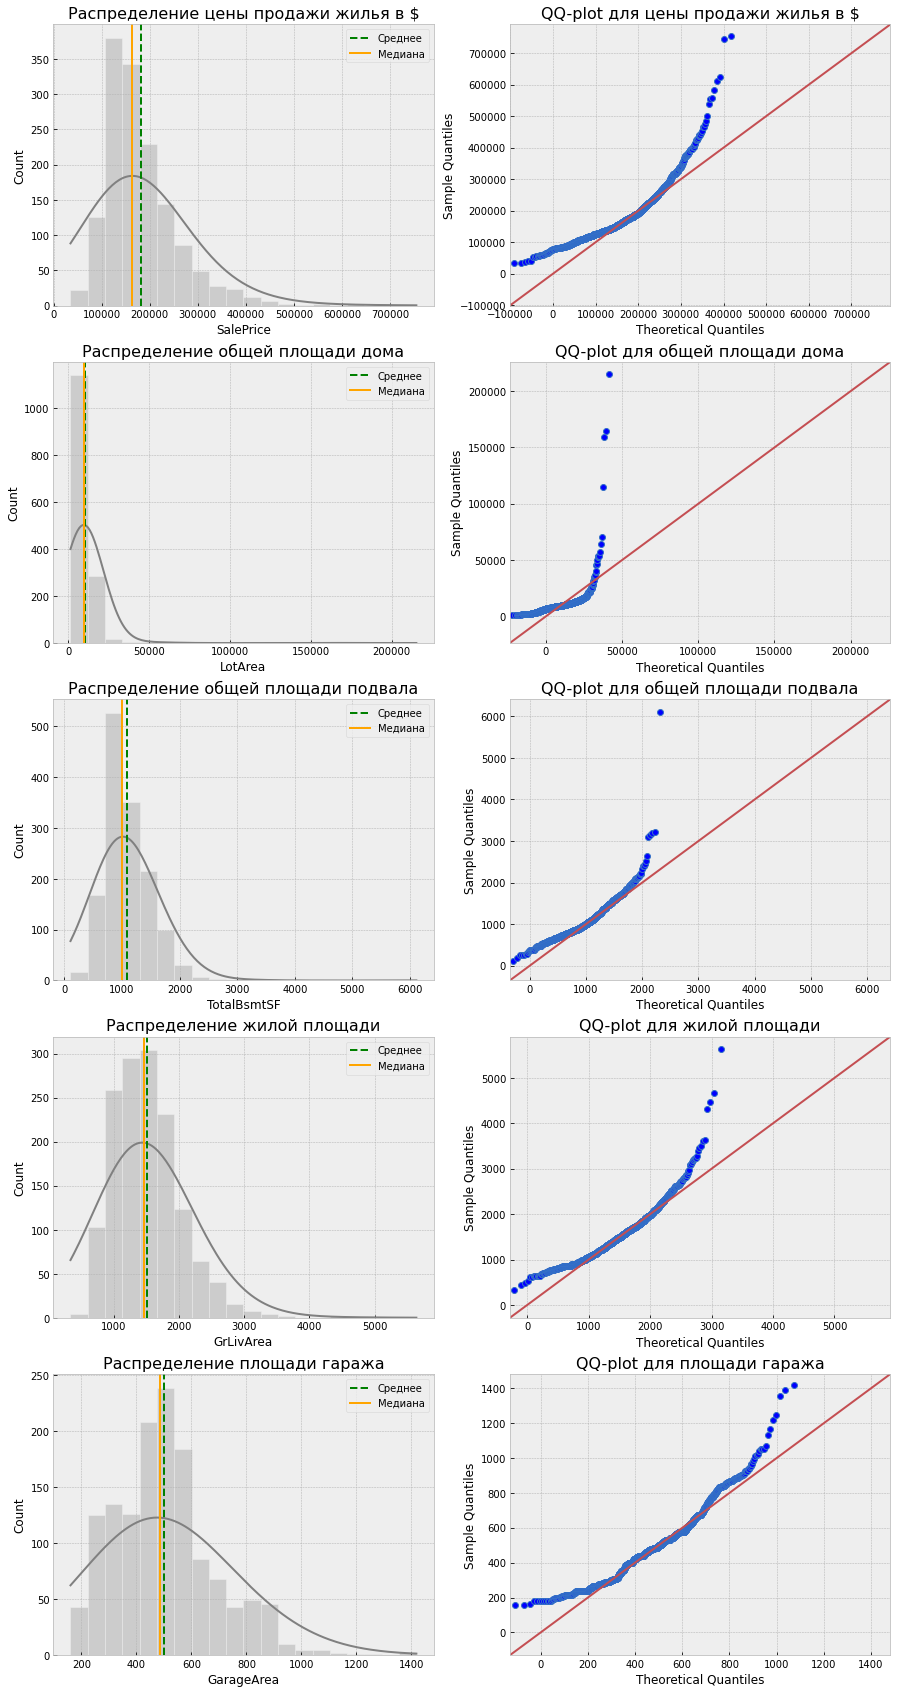

In [24]:
fig, ax = plt.subplots(5, 2, figsize=[15, 30])

ax[0,0].set_title('Распределение цены продажи жилья в $', size=16)
ax[1,0].set_title('Распределение общей площади дома', size=16)
ax[2,0].set_title('Распределение общей площади подвала', size=16)
ax[3,0].set_title('Распределение жилой площади', size=16)
ax[4,0].set_title('Распределение площади гаража', size=16)

ax[0,1].set_title('QQ-plot для цены продажи жилья в $', size=16)
ax[1,1].set_title('QQ-plot для общей площади дома', size=16)
ax[2,1].set_title('QQ-plot для общей площади подвала', size=16)
ax[3,1].set_title('QQ-plot для жилой площади', size=16)
ax[4,1].set_title('QQ-plot для площади гаража', size=16)

for i, k in zip(range(5), ['SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']):
    sns.histplot(df[df[k]!=0][k], bins=20, kde=True, kde_kws={'bw_adjust': 5}, color='gray', alpha=0.3, ax=ax[i,0])
    ax[i,0].axvline(x=df[df[k]!=0][k].mean(), color='green', linestyle='--')
    ax[i,0].axvline(x=df[df[k]!=0][k].median(), color='orange', linestyle='-')
    ax[i,0].legend([Line2D([0], [0], color='green', linestyle='--'),
            Line2D([0], [0], color='orange', linestyle='-')],
            ['Среднее',
            'Медиана'])

for i, k in zip(range(5), ['SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']):
    sm.qqplot(df[df[k]!=0][k], stats.norm(df[df[k]!=0][k].median(), df[df[k]!=0][k].std()), line='45', marker='o', ax=ax[i,1]);



На основе визуального анализа распределения отобранных числовых признаков можно заключить, что они распределены ненормально – присутствует асимметрия распределения.
Данный факт также подтверждают графики QQ-plot – точки сильно отклоняются от базовой линии, проходящей под углом 45 градусов.

Подтвердим заключение о ненормальности распределения признаков, сделанное на основе построенных графиков, расчетом показателей асимметрии и эксцесса.

In [25]:
skkur = pd.DataFrame()
skkur['index'] = ['skew', 'kurtosis']
for i in ['SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']:
    skkur[i] = [stats.skew(df[i]), stats.kurtosis(df[i])]
skkur.set_index('index', inplace=True)
skkur.index.name = None
skkur = skkur.round(2)
skkur.style.set_caption('Показатели асимметрии и эксцесса')


,SalePrice,LotArea,TotalBsmtSF,GrLivArea,GarageArea
skew,1.880000,12.200000,1.520000,1.370000,0.180000
kurtosis,6.510000,202.540000,13.200000,4.870000,0.910000


Рассчитанные показатели асимметрии и эксцесса также свидетельсвуют о том, что практически все признаки распределены ненормально – показатели не близки к нулю.
Однако, для признака GarageArea значение показателя асимметрии (0,18) достаточно близко к нулю, поэтому стоит осуществить проверку статистических гипотез в предположении нормальности распределения данных признаков.

Проверка гипотез о нормальности распределения признаков с помощью теста Шапиро

H0: признак имеет нормальное распределение

alpha = 0.05 (уровень значимости)

In [26]:
shapiro_test = pd.DataFrame()
shapiro_test['index'] = ['statistic', 'p-value']
for i in ['SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']:
    shapiro_test[i] = stats.shapiro(df[i])
shapiro_test.set_index('index', inplace=True)
shapiro_test.index.name = None
shapiro_test = round(shapiro_test, 2)
shapiro_test.style.set_caption('Результаты проверки гипотез о нормальности распределения признаков')

,SalePrice,LotArea,TotalBsmtSF,GrLivArea,GarageArea
statistic,0.870000,0.350000,0.920000,0.930000,0.980000
p-value,0.000000,0.000000,0.000000,0.000000,0.000000


Для всех 5ти переменных гипотеза H0 о нормальности распределения отвергается, все из указанных 5ти переменных распределены ненормально (pvalue<0.05).

Попробуем проверить нормальность по тесту Жака-Берра

In [27]:
jarque_bera_test = pd.DataFrame()
jarque_bera_test['index'] = ['statistic', 'p-value']
for i in ['SalePrice', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']:
    jarque_bera_test[i] = [stats.kstest(df[i], 'norm')[0], stats.kstest(df[i], 'norm')[1]]
jarque_bera_test.set_index('index', inplace=True)
jarque_bera_test.index.name = None
jarque_bera_test = round(jarque_bera_test, 2)
jarque_bera_test.style.set_caption('Результаты проверки гипотез о нормальности распределения признаков')

,SalePrice,LotArea,TotalBsmtSF,GrLivArea,GarageArea
statistic,1.000000,1.000000,0.970000,1.000000,0.940000
p-value,0.000000,0.000000,0.000000,0.000000,0.000000


Также нормальности нет

Попробуем преобразовать отобранные признаки путем логарифмирования (+1), посмотреть на распределение и осуществить проверку на нормальность.

In [28]:
log_part_df = pd.DataFrame({'SalePrice_log1p' : np.log1p(df['SalePrice']),
                            'LotArea_log1p' : np.log1p(df['LotArea']), 
                            'GrLivArea_log1p' : np.log1p(df[df['GrLivArea'] != 0]['GrLivArea'] ),     
                            'GarageArea_log1p' : np.log1p(df[df['GarageArea'] != 0]['GarageArea']),
                            'TotalBsmtSF_log1p' : np.log1p(df[df['TotalBsmtSF']!=0]['TotalBsmtSF'])})

In [29]:
log_part_df.head()

,SalePrice_log1p,LotArea_log1p,GrLivArea_log1p,GarageArea_log1p,TotalBsmtSF_log1p
0,12.247699,9.042040,7.444833,6.308098,6.753438
1,12.109016,9.169623,7.141245,6.133398,7.141245
2,12.317171,9.328212,7.488294,6.411818,6.825460
3,11.849405,9.164401,7.448916,6.466145,6.629363
4,12.429220,9.565284,7.695758,6.729824,7.044033


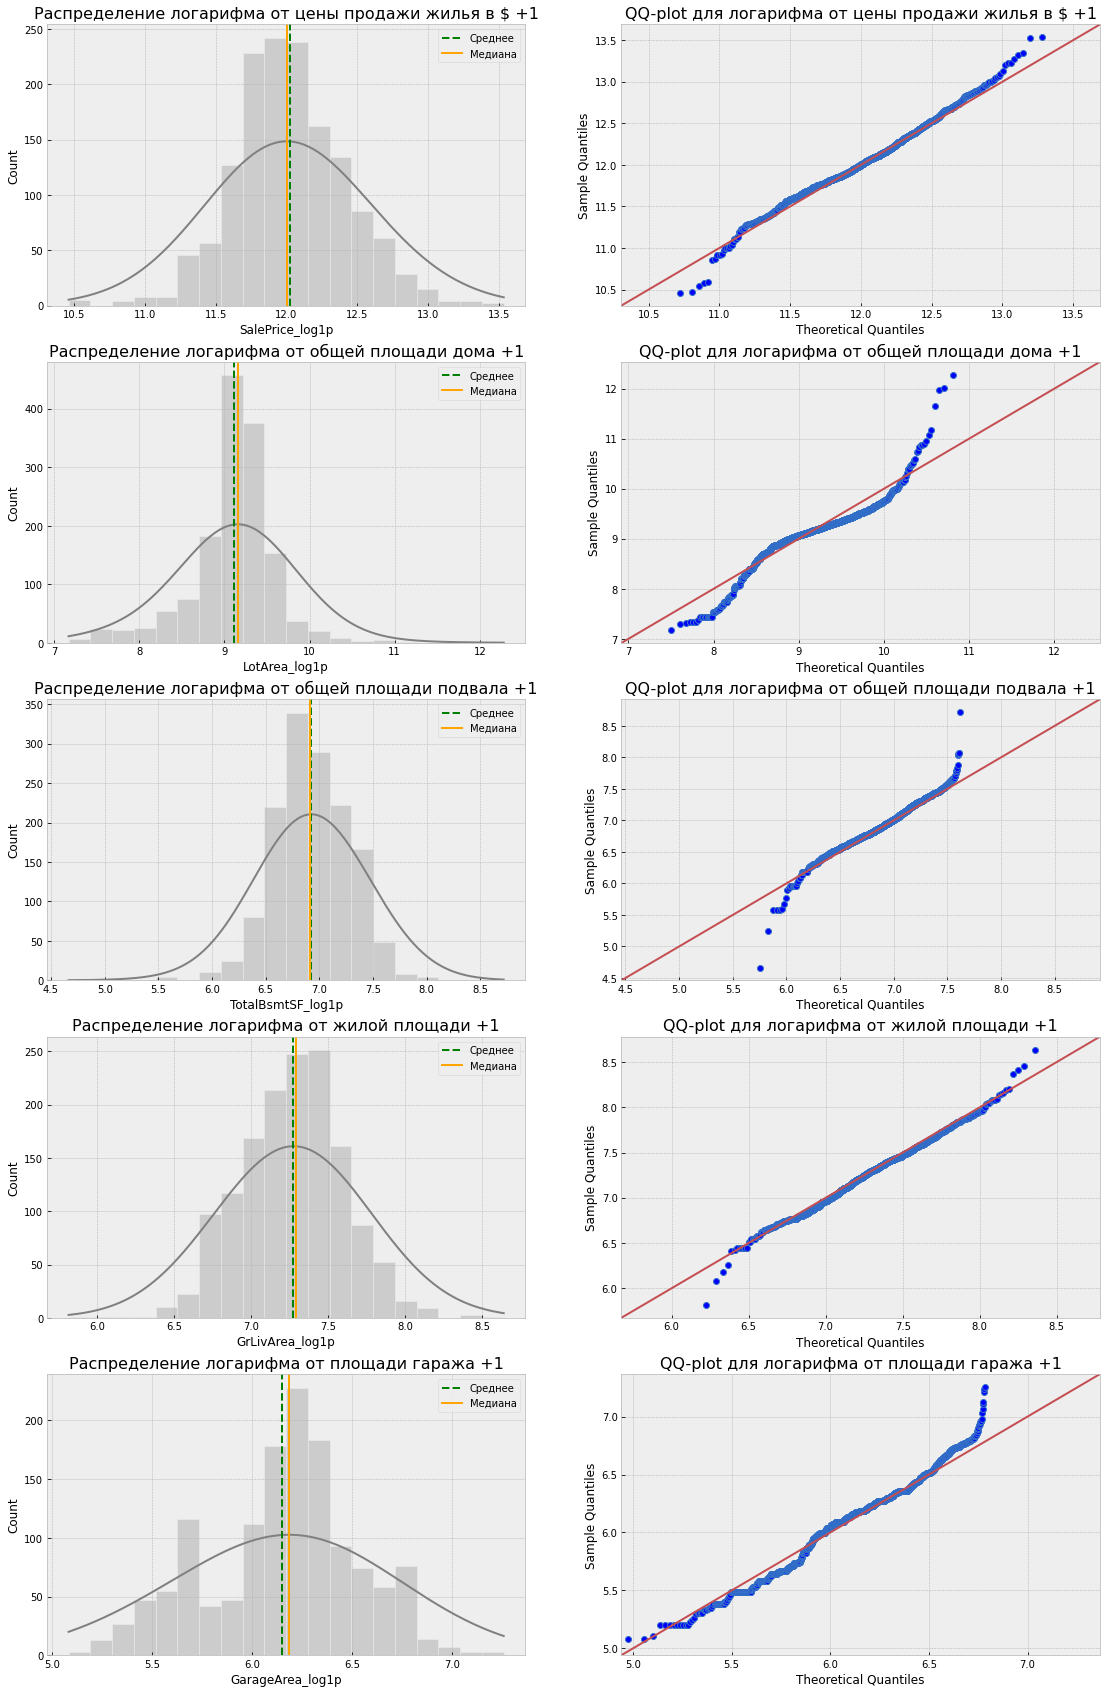

In [30]:
fig, ax = plt.subplots(5, 2, figsize=[15, 30])

ax[0,0].set_title('Распределение логарифма от цены продажи жилья в $ +1', size=16)
ax[1,0].set_title('Распределение логарифма от общей площади дома +1', size=16)
ax[2,0].set_title('Распределение логарифма от общей площади подвала +1', size=16)
ax[3,0].set_title('Распределение логарифма от жилой площади +1', size=16)
ax[4,0].set_title('Распределение логарифма от площади гаража +1', size=16)

ax[0,1].set_title('QQ-plot для логарифма от цены продажи жилья в $ +1', size=16)
ax[1,1].set_title('QQ-plot для логарифма от общей площади дома +1', size=16)
ax[2,1].set_title('QQ-plot для логарифма от общей площади подвала +1', size=16)
ax[3,1].set_title('QQ-plot для логарифма от жилой площади +1', size=16)
ax[4,1].set_title('QQ-plot для логарифма от площади гаража +1', size=16)

for i, k in zip(range(5), ['SalePrice_log1p', 'LotArea_log1p', 'TotalBsmtSF_log1p', 'GrLivArea_log1p', 'GarageArea_log1p']):
    sns.histplot(log_part_df[k], bins=20, kde=True, kde_kws={'bw_adjust': 5}, color='gray', alpha=0.3, ax=ax[i,0])
    ax[i,0].axvline(x=log_part_df[k].mean(), color='green', linestyle='--')
    ax[i,0].axvline(x=log_part_df[k].median(), color='orange', linestyle='-')
    ax[i,0].legend([Line2D([0], [0], color='green', linestyle='--'),
            Line2D([0], [0], color='orange', linestyle='-')],
            ['Среднее',
            'Медиана'])

for i, k in zip(range(5), ['SalePrice_log1p', 'LotArea_log1p', 'TotalBsmtSF_log1p', 'GrLivArea_log1p', 'GarageArea_log1p']):
    sm.qqplot(log_part_df[k], stats.norm(log_part_df[k].median(), log_part_df[k].std()), line='45', marker='o', ax=ax[i,1]);
    
plt.subplots_adjust(right = 1.1)

На основе визуального анализа распределения логарифмов от отобранных числовых признаков +1 можно заключить, что они скорее распределены ненормально – присутствует асимметрия распределения и выбросы. Хотя графики логарифмов от цены продажи жилья +1 и от общей площади подвала +1 имеют большое сходство с нормальным. Поэтому стоит проверить данное предположение посредством анализа асимметрии и эксцесса, а также проверки статистических гипотез.
Факт того, что логарифмы признаков +1 скорее распределены ненормально, чем наоборот, также подтверждают графики QQ-plot – точки сильно отклоняются от базовой линии, проходящей под углом 45 градусов (особенно для логарифма от общей площади дома, логарифма от площади гаража +1 ).

Анализ показателей асимметрии и эксцесса

In [31]:
skkur_log = pd.DataFrame()
skkur_log['index'] = ['skew', 'kurtosis']
for i in ['SalePrice_log1p', 'LotArea_log1p', 'GrLivArea_log1p', 'GarageArea_log1p', 'TotalBsmtSF_log1p']:
    skkur_log[i] = [stats.skew(log_part_df[i].dropna()), stats.kurtosis(log_part_df[i].dropna())]
skkur_log.set_index('index', inplace=True)
skkur_log.index.name = None
skkur_log = skkur_log.round(2)
skkur_log.style.set_caption('Показатели асимметрии и эксцесса')

,SalePrice_log1p,LotArea_log1p,GrLivArea_log1p,GarageArea_log1p,TotalBsmtSF_log1p
skew,0.120000,-0.140000,-0.010000,-0.250000,-0.270000
kurtosis,0.800000,4.690000,0.280000,-0.230000,1.910000


Итак, показатели асимметрии и эксцесса для логарифма от цены продажи жилья +1 и логарифма от общей площади подвала подтвердили наше предположение о том, что данные переменные могут быть распределены нормально. Осталось подтвердить это предположение с помощью проверки статистичесих гипотез о нормальности распределения.

Проверка гипотез о нормальности распределения логарифмов признаков +1 с помощью теста Шапиро.

H0: признак имеет нормальное распределение

alpha = 0.05 (уровень значимости)

In [32]:
shapiro_test = pd.DataFrame()
shapiro_test['index'] = ['statistic', 'p-value']
for i in ['SalePrice_log1p', 'LotArea_log1p', 'GrLivArea_log1p', 'GarageArea_log1p', 'TotalBsmtSF_log1p']:
    shapiro_test[i] = stats.shapiro(log_part_df[i].dropna())
shapiro_test.set_index('index', inplace=True)
shapiro_test.index.name = None
shapiro_test = round(shapiro_test, 2)
shapiro_test.style.set_caption('Результаты проверки гипотез о нормальности распределения признаков')

,SalePrice_log1p,LotArea_log1p,GrLivArea_log1p,GarageArea_log1p,TotalBsmtSF_log1p
statistic,0.990000,0.910000,1.000000,0.990000,0.980000
p-value,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
jarque_bera_test = pd.DataFrame()
jarque_bera_test['index'] = ['statistic', 'p-value']
for i in ['SalePrice_log1p', 'LotArea_log1p', 'GrLivArea_log1p', 'GarageArea_log1p', 'TotalBsmtSF_log1p']:
    jarque_bera_test[i] = stats.jarque_bera(log_part_df[i].dropna())
jarque_bera_test.set_index('index', inplace=True)
jarque_bera_test.index.name = None
jarque_bera_test = round(jarque_bera_test, 2)
jarque_bera_test.style.set_caption('Результаты проверки гипотез о нормальности распределения признаков')

,SalePrice_log1p,LotArea_log1p,GrLivArea_log1p,GarageArea_log1p,TotalBsmtSF_log1p
statistic,42.770000,1344.730000,4.670000,17.250000,234.030000
p-value,0.000000,0.000000,0.100000,0.000000,0.000000


Все представленные 5 логарифмов от переменных +1 распределены ненормально (гипотеза H0 о нормальности распределения отвергается, pvalue<0.05) по тесту Шапиро. По тесту Жака-Берра общая площадь дома имеет нормальное распределение